# Keras Experiments - Image Blur
Keras is a well-known tensorflow wrapper library used to make deep learning models. I have been using it extensively and have started machine vision-related experiments with it. I currently use opencv for image processing, but I started to wonder whether I can use the convolutional layer in keras/tensorflow to achieve the same results at similar/faster speed. Practically speaking there is no reason to use keras for this task but I decided to run a quick experimentation because I could.

In this article I will use keras with a single convolutional layer to blur an image. I will not train a model and assign the blurring filters to the layer manually. Why do this?
* This will deepen my own understanding and ensure that keras behaves as expected. 
* I want to explore whether in this case openCV or keras/tensorflow is more optimized to perform this task.
* I will also want to explore what configurations I can change to optimize processing speed.

The libraries for this task will be keras, tensorflow, numpy for some array processing, matplotlib to show images, and opencv2 for image loading processing and comparison.

In [1]:
# Uncomment following lines to force CPU processing:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.python.keras import backend as K

plt.style.use('ggplot') # for matplotlib because it looks nice

The following versions were used for reference. That way if it turns out that there were some optimizations that were done, I can alawys blame that particular release.

In [2]:
print(f'Available devices for Keras: {K._get_available_gpus()}')
print(f'Keras version: {keras.__version__}')
print(f'Tensorflow version: {tf.__version__}')
print(f'OpenCV2 version: {cv2.__version__}')

Available devices for Keras: ['/device:GPU:0']
Keras version: 2.2.4-tf
Tensorflow version: 2.1.0
OpenCV2 version: 4.5.4-dev


## Image blur via Gaussian kernel
Convolution applies an operation to each pixel in the image by using a small matrix called a kernel. The surrouunding pixels will also contibute to the value of the central pixel depending on the size of the kernel. For example a 3x3 matrix kernel full of 1/9 values will mean that the value of a pixel in the output image is the average of the  central pixel and the 8 surrounding pixels. This sort of averaging is very good to remove high frequency noise in an image, but tends to wash out the edges.  

In this article I will generate a Gaussian kernel, which gives most importance to the center pixel and less importance to more distant pixels. The 7x7 kernel is shown in the following image: 

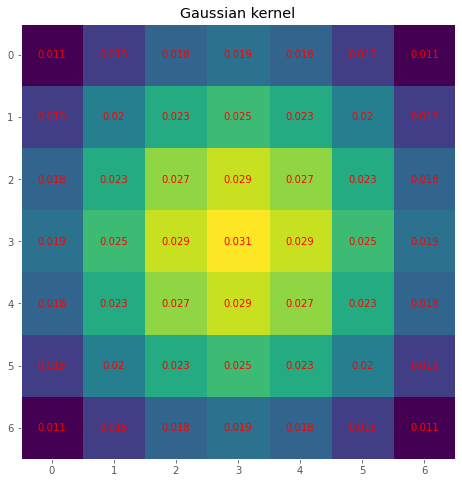

In [3]:
def gaussian_kernel(kernel_size: int = 5, sigma: float =1.0):
    """Generates a symmetric 2D Gaussian kerner

    Args:
        kernel_size (int, optional): edge length of kernel. Defaults to 5.
        sigma (float, optional): Kernel variance. Larger values give more weight to further pixels. 
                                    Defaults to 1.0.
    """
    ax = np.linspace(-(kernel_size - 1) / 2.0, (kernel_size - 1) / 2.0, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# Generate kernel and plot
gauss_kernel = gaussian_kernel(kernel_size=7, sigma=3)
fig1, ax= plt.subplots(1, figsize=(8,8))
plt.grid(False)
ax.imshow(gauss_kernel)
for (j,i),label in np.ndenumerate(gauss_kernel):
    ax.text(i,j,f'{label:2.2}',ha='center',va='center', color='red')
title=ax.set_title('Gaussian kernel')

## OpenCV image blur
I will use opencv to load a sample color image of size 1280 x 960 resolution with 3 color channels. The image transformation can be achieved in (at least) two ways:
* I can run cv2.GaussianBlur function to blur the image directly
* I can use cv2.filter2D to apply a 2d matrix to each pixel. This is the preferred method since I can set the kernel and use it directly in the keras convolutional layer.

The following is a comparison of the original image to the blurred image using cv2 and the generated kernel.

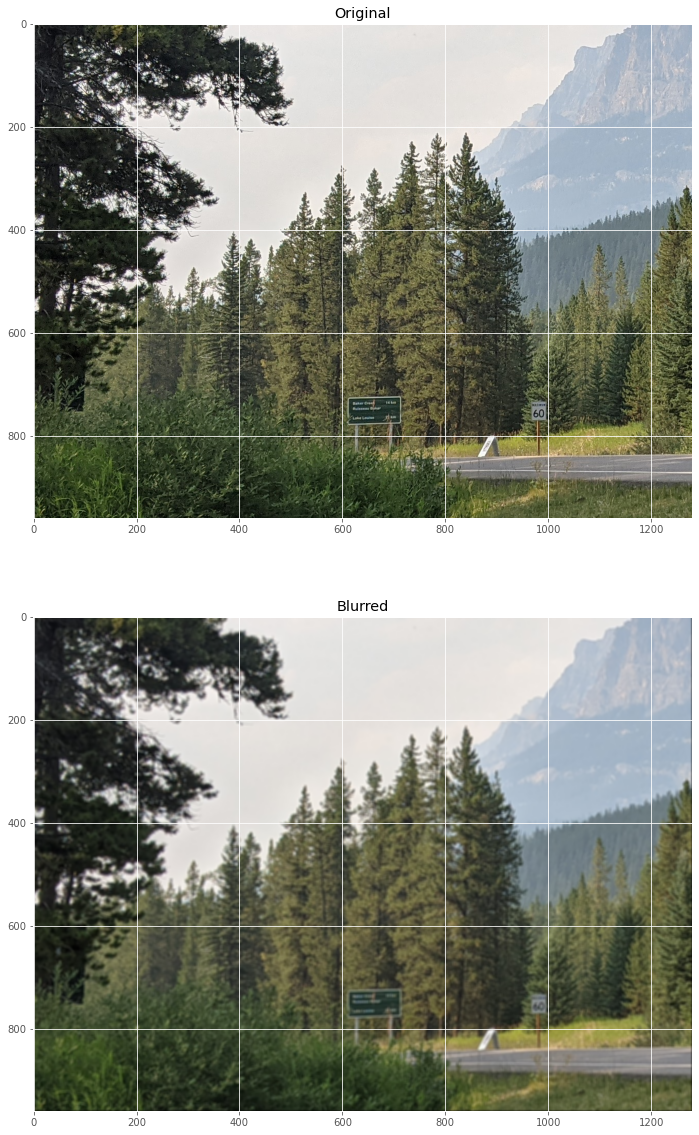

In [4]:
# read sample image from file
raw_image = cv2.imread('./sample_image.png')

#Display original raw image
fig, ax = plt.subplots(2,1,figsize=(20,20))
ax[0].imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
title1=ax[0].set_title('Original')

# Display blurred image
blurred_image = cv2.filter2D(raw_image,-1,gauss_kernel, borderType=cv2.BORDER_CONSTANT)
ax[1].imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
title2=ax[1].set_title('Blurred')

## Keras image blur
I will create a model with a single layer that applies the Gaussian kernel to the input image to produce a blurred output image of the same size. I will make two models, which will only differ in the data type for the layers. The default keras layers use float32 for numerical values, but you can also use half-precision float16 values, which can reduce the required GPU memory and allow you to train larger models. I am only using a small layer with a single 7x7 kernel so half precision is not necessary, but I am curious what the resulting speed difference will be.   

The layer use the following parameters:
* The DepthwiseConv2D layer applies each kernel to a single image channel and concatenates them to preserve the 3 channels in the output image. The Conv2D would have applied the kernel to all channels at once and produces a single channel gray scale image.
* The padding='same' argument ensures that the output image has the same dimensions as the input image.
* I indicate the data type as float32 or float16 for the half precision model.
* The use_bias parameter=False since we are only applying the filter to them.

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import DepthwiseConv2D 


# Define blurring model with layer with default dtype
model_default = Sequential(name='Image_Blur')
blur_layer_1_default = DepthwiseConv2D(input_shape= (960,1280,3), 
                               kernel_size=(7,7),
                               padding='same',
                               dtype='float32',
                               use_bias=False)
model_default.add(blur_layer_1_default)
model_default.summary()

print('\nAlternate Model:')
# Define blurring model with layer with dtype=float16
model_float16 = Sequential(name='Image_Blur_dtype_float16')
blur_layer_1_float16 = DepthwiseConv2D(input_shape= (960,1280,3), 
                               kernel_size=(7,7),
                               padding='same',
                               dtype='float16',
                               use_bias=False)
model_float16.add(blur_layer_1_float16)
model_float16.summary()

Model: "Image_Blur"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC (None, 960, 1280, 3)      147       
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________

Alternate Model:
Model: "Image_Blur_dtype_float16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_1 (Depthwis (None, 960, 1280, 3)      147       
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


The layer is initialized with random weights. We can control them somewhat by using [keras weight initializers](https://keras.io/api/layers/initializers/), but in this experiment I will manually assign the layer values to match the Gaussian kernel. 

What does it look like when we fire the input image through randomly genereated weights? It will look like a random mess with pixel values outside the viewable range(a lot of black/white), negative values, and colour changes since the sum of the filter is not 1, but still kind of nice: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Random Convolutional Kernel')

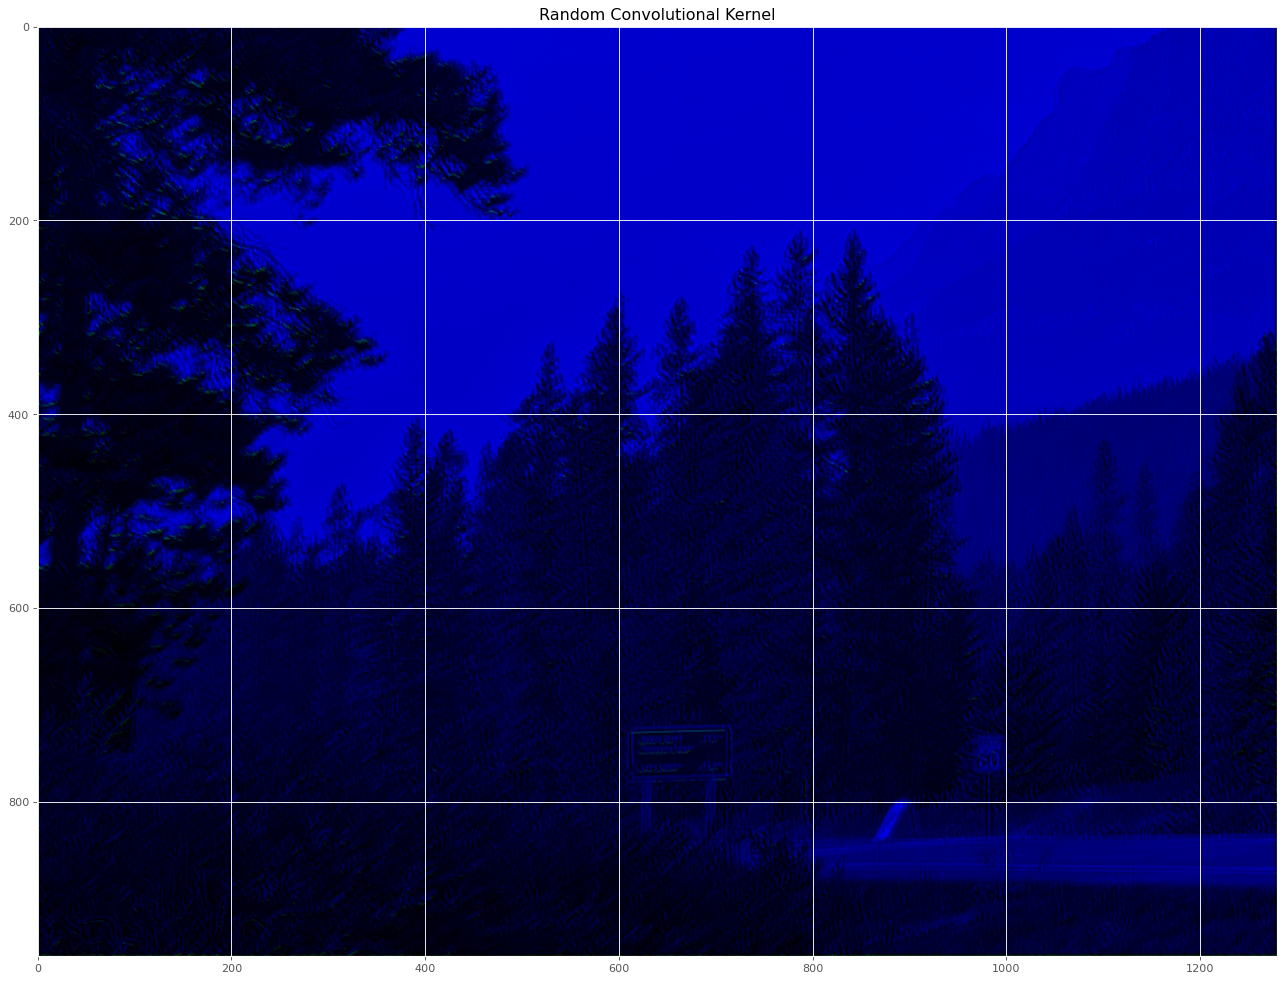

In [6]:
input_image = np.expand_dims(raw_image, axis=0) # convert dimension to 1x960x1280x3 for batch with single image 
output_image = model_default.predict(input_image)
output_image = np.squeeze(output_image, axis=0)

plt.figure(figsize=(20,20), dpi=80)
plt.imshow(output_image[:,:, [2,1,0]].astype(int)) # convert bgr to rgb via channel inversion
plt.title('Random Convolutional Kernel')

The random convolutional kernel looks trippy, but instead let's assign the Gaussian kernel. The depthwise convolutional layer will assign a filter for each channel so we have to stack the Gaussian smoothing kernel along each axis.

In [7]:
# Create new convolutional layer and assign to blur layer
new_weights = np.stack([gauss_kernel, gauss_kernel,gauss_kernel], axis=2)
new_weights = np.expand_dims(new_weights, axis=-1)
blur_layer_1_default.set_weights([new_weights])
blur_layer_1_float16.set_weights([new_weights])

## Processing speed comparison

The speed of keras vs opencv will be compared here. I will blur the image 100 times and compare the time it took to accomplish this task. I will also compare keras with GPU support (GeForce GTX 1660 Ti) vs. keras with CPU processing. For the CPU processing I am having to restart python and make hide the GPU from the keras import. There are ways to force the selection of the device, but those did not immediately work for me.

In [8]:
from datetime import datetime
import cv2

n_images = 100
now = datetime.now()
output_image_keras = model_default.predict(np.repeat(input_image, n_images, axis=0))    
time_keras_default = datetime.now() - now
print(f'Duration: {time_keras_default} for {n_images} images using keras with dtype=float32')

now = datetime.now()
output_image_keras = model_float16.predict(np.repeat(input_image, n_images, axis=0))    
time_keras_float_16=datetime.now() - now
print(f'Duration: {time_keras_float_16} for {n_images} images using keras with dtype=float16')

now = datetime.now()
for n in range(0,n_images):
    output_image_cv2_filter = cv2.filter2D(raw_image,-1,gauss_kernel, borderType=cv2.BORDER_CONSTANT)
time_cv2_filter2d =datetime.now() - now 
print(f'Duration: {time_cv2_filter2d} for {n_images} images using cv2.filter2D function'  )

now = datetime.now()
for n in range(0,n_images):
    output_image_cv2_gb = cv2.GaussianBlur(raw_image,(7,7), sigmaX=3, sigmaY=3)
time_cv2_gauss_blur =datetime.now() - now 
print(f'Duration: {time_cv2_gauss_blur} for {n_images} images using cv2.GaussianBlur'  )

Duration: 0:00:02.006597 for 100 images using keras with dtype=float32
Duration: 0:00:01.208518 for 100 images using keras with dtype=float16
Duration: 0:00:01.406886 for 100 images using cv2.filter2D function
Duration: 0:00:00.126660 for 100 images using cv2.GaussianBlur


Print the images for comparisson of openCV vs keras blurred images:

Text(0.5, 1.0, 'Image blurred by cv2.GaussianBlur')

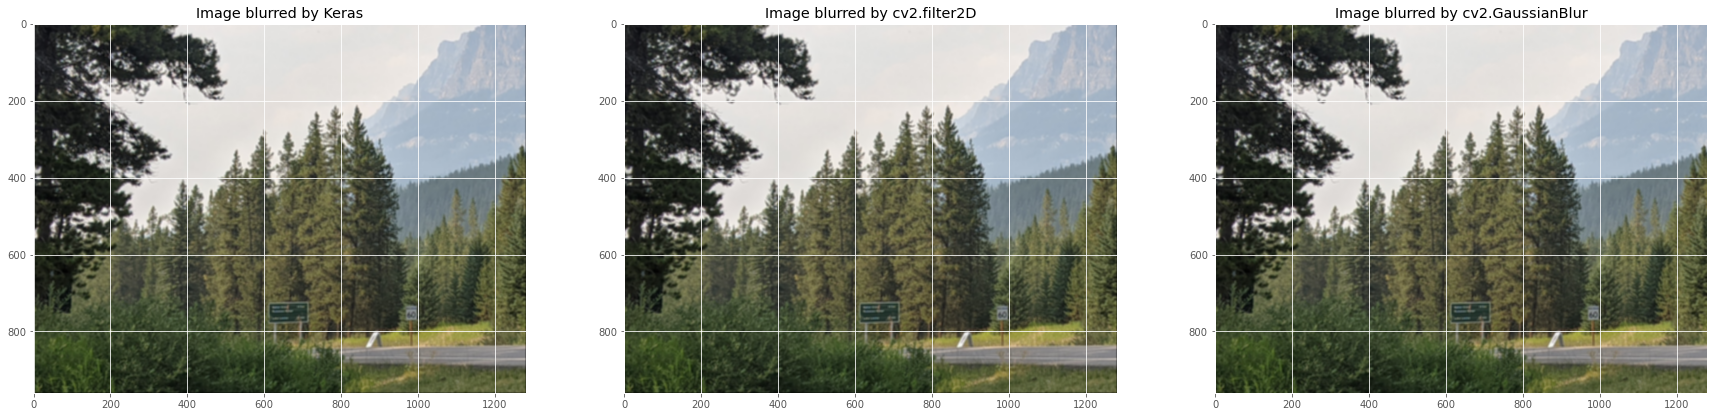

In [9]:
image_keras = np.squeeze(output_image_keras[0,:,:,:])

fig, ax = plt.subplots(1,3,figsize=(30,30))
ax[0].imshow(image_keras[:,:,[2,1,0]].astype(int))
ax[0].set_title('Image blurred by Keras')

ax[1].imshow(cv2.cvtColor(output_image_cv2_filter, cv2.COLOR_BGR2RGB))
ax[1].set_title('Image blurred by cv2.filter2D')

ax[2].imshow(cv2.cvtColor(output_image_cv2_gb, cv2.COLOR_BGR2RGB))
ax[2].set_title('Image blurred by cv2.GaussianBlur')

Generate a plot that compares the relative speeds of image blurring for the six different methods:

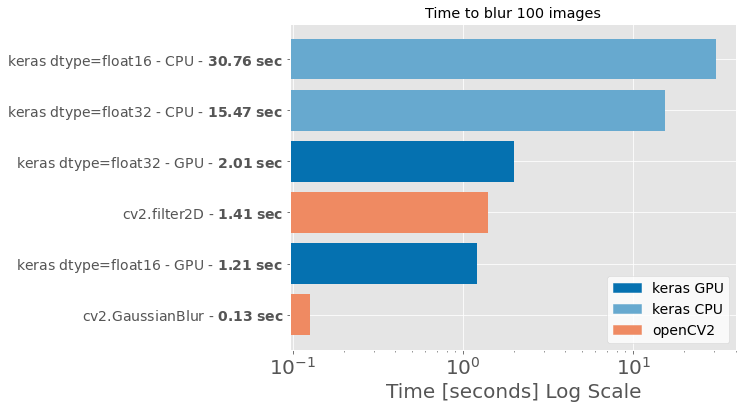

In [10]:
KERAS_GPU_COLOR = (0.020, 0.443, 0.690)
KERAS_CPU_COLOR = (0.404,0.663,0.812)
CV2_COLOR = (0.937, 0.541, 0.384)

legend_patches = [mpatches.Patch(color=KERAS_GPU_COLOR, label='keras GPU'),
                  mpatches.Patch(color=KERAS_CPU_COLOR, label='keras CPU'),
                  mpatches.Patch(color=CV2_COLOR, label='openCV2')]

description_list = ['keras dtype=float16 - CPU',
                    'keras dtype=float32 - CPU',
                    'keras dtype=float32 - GPU',
                    'keras dtype=float16 - GPU',
                    'cv2.filter2D',
                    'cv2.GaussianBlur'
                   ]
time_list = [30.758763, # from previous CPU test
             15.466722,  # from previous CPU test
             time_keras_default.total_seconds(),
             time_keras_float_16.total_seconds(),
             time_cv2_filter2d.total_seconds(),
             time_cv2_gauss_blur.total_seconds()
            ]
color_list = [KERAS_CPU_COLOR, KERAS_CPU_COLOR,
             KERAS_GPU_COLOR, KERAS_GPU_COLOR,
             CV2_COLOR, CV2_COLOR]
for idx,time in enumerate(time_list):
    description_list[idx]  = description_list[idx] + " - " + r"$\bf{" + f'{time:2.2f}'+ " \;sec}$" #f'{description_list[idx]} - $\bf\{{time:2.2f} sec\}$'
# Sort lists by time
sort_idx = np.argsort(time_list)
description_list = [description_list[idx] for idx in sort_idx]
time_list = [time_list[idx] for idx in sort_idx]
color_list = [color_list[idx] for idx in sort_idx]
    
# generate figure
ax = plt.figure(figsize=(8,6)).add_subplot(1, 1, 1)
ax.barh(description_list, time_list,color=color_list, align='center')
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('Time [seconds] Log Scale',  fontsize=20)
ax.set_title(f'Time to blur {n_images} images')
leg = ax.legend(handles=legend_patches, fontsize = 14, facecolor='white')

## Key Takeaways
* The openCV GaussianBlur function is the fastest, but it applies a 1d filter across all image dimensions. This makes the function fast (as evidenced by the above processing time), but we can't really compare the output to the other methods because it is numerically quite different.
*  The keras-produced output and the cv2.filter2D function output are numerically very close (within some small error when truncating floats to ints).
* CPU processing of keras data is much slower than GPU, which is expected. The surprising (and not immediately obvious) resut is that half precision processing (dtype=float16) on a CPU takes twice as long. The CPU is likely less optimized for processing with float16 types.
* Setting the precision on GPUs from dtype=float32 to dtype=float16 speeds up processing by about 40%. The code in this experiment did not do any training so we don't need to compute gradients. There is a lot of debate online about whether the smaller/mixed precision is valid for convolutional neural networks.
* openCV2 is surprisingly efficent at applying filters to images and matches keras GPU performance. OpenCV has been in development since 2000 and the python library is a wrapper for the C/C++ code so it is well optimized. It would be intresting to further explore a combination of opencv with a keras layer for fast CPU processing. There are deep neural network modules for opencv, but those are not quite as well known as keras. 